In [182]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

Загружаем нестационарный ряд и преобразуем его в стационарный

In [183]:
nonstat = pd.read_csv("Series\international-airline-passengers.csv")['Count']
dftest = adfuller(nonstat, autolag='AIC')
print('p=value =', dftest[1])

p=value = 0.9918802434376409


In [184]:
nonstat1 = boxcox(nonstat, 0)
nonstat1 = nonstat1[1:] - nonstat1[:-1]
stat = nonstat1[12:] - nonstat1[:-12]
dftest = adfuller(stat, autolag='AIC')
print('p=value =', dftest[1])

p=value = 0.0002485912311384209


In [185]:
nonstat = pd.Series(nonstat)
stat = pd.Series(stat)

Устанавливаем размер тестовой выборки

In [202]:
N_pred = 30

Делим ряды на трейн и тест

In [203]:
nonstat_train = nonstat[:-N_pred]
nonstat_test = nonstat[-N_pred:]
stat_train = stat[:-N_pred]
stat_test = stat[-N_pred:]

Функция для расчета скользящей средней

In [204]:
def MA(series, n, n_pred):
    s_pred = list(series.rolling(n).mean())
    for _ in range(n_pred):
        x = sum(s_pred[-n:]) / n
        s_pred.append(x)
    return pd.Series(s_pred)

Функция для расчета экспоненциального сглажиания

In [205]:
def EMA(series, alpha, n_pred):
    s_pred = [series[0]]
    for i in range(1, len(series)):
        x = alpha * series[i] + (1 - alpha) * s_pred[i - 1]
        s_pred.append(x)
    for _ in range(n_pred):
        x = alpha * s_pred[-1] + (1 - alpha) * s_pred[-2]
        s_pred.append(x)
    return pd.Series(s_pred)

Функция для расчета двойного экспоненциального сглаживания

In [206]:
def DEMA(series, alpha, beta, n_pred):
    res = [series[0]]
    l, t = series[0], series[1] - series[0]
    lm, tm = [l], [t]
    for i in range(1, len(series)):
        last_l = l
        l = alpha * series[i] + (1 - alpha) * (l + t)
        t = beta * (l - last_l) + (1 - beta) * t
        lm.append(l)
        tm.append(t)
        res.append(l + t)
    for _ in range(n_pred):
        last_l = l
        l = alpha * res[-1] + (1 - alpha) * (l + t)
        t = beta * (l - last_l) + (1 - beta) * t
        lm.append(l)
        tm.append(t)
        res.append(l + t)
    return pd.Series(res)

Функции для расчета тройного экспоненциального сглаживания

In [207]:
def init_season(series, tau):
    seasonals = {}
    season_avg = []
    n = int(len(series) / tau)
    for j in range(n):
        season_avg.append(sum(series[tau*j:tau*(j+1)]) / float(tau))
    for i in range(tau):
        sum_avg = 0.0
        for j in range(n):
            sum_avg += series[tau*j+i] - season_avg[j]
        seasonals[i] = sum_avg / n
    return seasonals

In [208]:
def TEMA(series, tau, alpha, beta, gamma, n_pred):
    res = []
    seasonals = init_season(series,tau)
    for i in range(len(series)+n_pred):
        if i == 0:
            smooth = series[0]
            trend = sum([float(series[tau]-series[0]) / tau])
            res.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            res.append(smooth + m*trend + seasonals[i % tau])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i % tau]) + (1-alpha)*(smooth+trend)
            trend = beta*(smooth-last_smooth) + (1-beta)*trend
            seasonals[i % tau] = gamma*(val-smooth) + (1-gamma)*seasonals[i % tau]
            res.append(smooth + trend + seasonals[i % tau])
    
    return pd.Series(res)

Находим оптимальные гиперпараметры и метрики для каждого алгоритма

In [209]:
def MA_mae(X, *args):
    n = int(X)
    res = MA(args[0], n, N_pred)
    predict = res[-N_pred:]
    error = mean_absolute_error(predict, args[1])
    return error

MA_nonstat = minimize(MA_mae, x0=1, args=(nonstat_train, nonstat_test), method='L-BFGS-B')
MA_stat = minimize(MA_mae, x0=1, args=(stat_train, stat_test), method='L-BFGS-B')

In [210]:
def EMA_mae(X, *args):
    alpha = X
    res = EMA(args[0], alpha, N_pred)
    predict = res[-N_pred:]
    error = mean_absolute_error(predict, args[1])
    return error

EMA_nonstat = minimize(EMA_mae, x0=0.1, args=(nonstat_train, nonstat_test), method='L-BFGS-B')
EMA_stat = minimize(EMA_mae, x0=0.1, args=(stat_train, stat_test), method='L-BFGS-B')

In [211]:
def DEMA_mae(X, *args):
    alpha, beta = X
    res = DEMA(args[0], alpha, beta, N_pred)
    predict = res[-N_pred:]
    error = mean_absolute_error(predict, args[1])
    return error

DEMA_nonstat = minimize(DEMA_mae, x0=[0,0], args=(nonstat_train, nonstat_test), method='L-BFGS-B', bounds=((0,1),(0,1)))
DEMA_stat = minimize(DEMA_mae, x0=[0,0], args=(stat_train, stat_test), method='L-BFGS-B', bounds=((0,1),(0,1)))

In [212]:
def TEMA_mae(X, *args):
    alpha, beta, gamma = X
    res = TEMA(args[0], 12, alpha, beta, gamma, N_pred)
    predict = res[-N_pred:]
    error = mean_absolute_error(predict, args[1])
    return error

TEMA_nonstat = minimize(TEMA_mae, x0=[0,0,0], args=(nonstat_train, nonstat_test), method='L-BFGS-B', bounds=((0,1),(0,1),(0,1)))
TEMA_stat = minimize(TEMA_mae, x0=[0,0,0], args=(stat_train, stat_test), method='L-BFGS-B', bounds=((0,1),(0,1),(0,1)))

Строим графики для нестационарного ряда

In [213]:
ma_nonstat_pred = MA(nonstat_train, int(MA_nonstat.x[0]), N_pred)
ema_nonstat_pred = EMA(nonstat_train, EMA_nonstat.x[0], N_pred)
dema_nonstat_pred = DEMA(nonstat_train, DEMA_nonstat.x[0], DEMA_nonstat.x[1], N_pred)
tema_nonstat_pred = TEMA(nonstat_train, 12, TEMA_nonstat.x[0], TEMA_nonstat.x[1], TEMA_nonstat.x[2], N_pred)

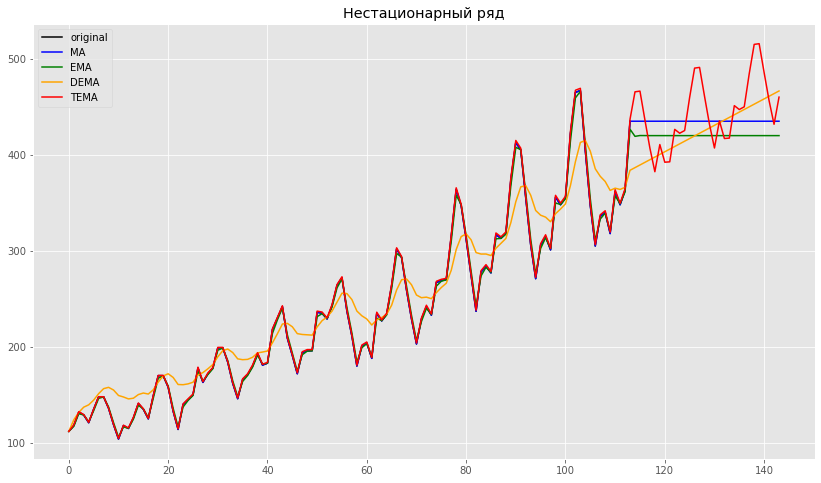

In [214]:
with plt.style.context("ggplot"):
    plt.figure(figsize=[14,8])
    plt.plot(nonstat_train, color='black', label='original')
    plt.plot(ma_nonstat_pred, color='blue', label='MA')
    plt.plot(ema_nonstat_pred, color='green', label='EMA')
    plt.plot(dema_nonstat_pred, color='orange', label='DEMA')
    plt.plot(tema_nonstat_pred, color='red', label='TEMA')
    plt.title('Нестационарный ряд')
    plt.legend()

Строим графики для стаионарного ряда

In [215]:
ma_stat_pred = MA(stat_train, int(MA_stat.x[0]), N_pred)
ema_stat_pred = EMA(stat_train, EMA_stat.x[0], N_pred)
dema_stat_pred = DEMA(stat_train, DEMA_stat.x[0], DEMA_stat.x[1], N_pred)
tema_stat_pred = TEMA(stat_train, 12, TEMA_stat.x[0], TEMA_stat.x[1], TEMA_stat.x[2], N_pred)

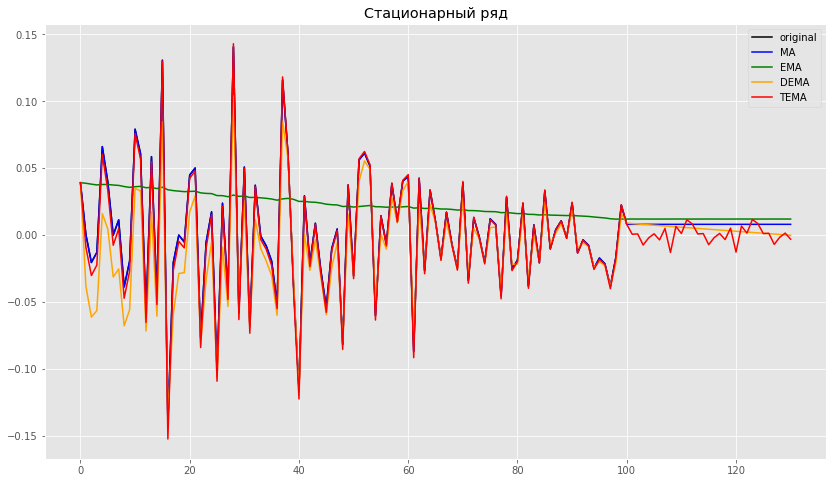

In [216]:
with plt.style.context("ggplot"):
    plt.figure(figsize=[14,8])
    plt.plot(stat_train, color='black', label='original')
    plt.plot(ma_stat_pred, color='blue', label='MA')
    plt.plot(ema_stat_pred, color='green', label='EMA')
    plt.plot(dema_stat_pred, color='orange', label='DEMA')
    plt.plot(tema_stat_pred, color='red', label='TEMA')
    plt.title('Стационарный ряд')
    plt.legend()

Выводим значения метрик

In [217]:
table = pd.DataFrame([['Нестационарный ряд',MA_nonstat.fun,EMA_nonstat.fun,DEMA_nonstat.fun,TEMA_nonstat.fun],
                      ['Стационарный ряд',MA_stat.fun,EMA_stat.fun,DEMA_stat.fun,TEMA_stat.fun]],
columns=['Тип','MA','EMA','DEMA','TEMA'])
print('Значения MAE для различных алгоритмов сглаживания:')
table

Значения MAE для различных алгоритмов сглаживания:


,Тип,MA,EMA,DEMA,TEMA
0,Нестационарный ряд,62.866667,61.688674,57.321882,36.831579
1,Стационарный ряд,0.032915,0.032880,0.032529,0.033662


Для нестационарного ряда лучшей предсказательной моделью оказалась TEMA, поскольку она учитывает и тренд, и сезонность. 
В стационарном ряду сезонности и тренда нет, поэтому здесь лучшей оказывается DEMA.